
# PROGRAMMING LANGUAGE TRENDS — STACK OVERFLOW TAGS OVER TIME

This notebook analyzes **Stack Overflow** tag usage over time to approximate the relative popularity of major programming languages.
We clean the CSV export, reshape it to a time series by language, explore key patterns, and smooth the series with a rolling mean.


In [8]:
import pandas as pd
import matplotlib.pyplot as plt

pd.options.display.float_format = '{:,.0f}'.format


## Get the Data

Use the provided `QueryResults.csv` or export your own from Stack Exchange Data Explorer (same schema):  
- Query link: https://data.stackexchange.com/stackoverflow/query/675441/popular-programming-languages-per-over-time-eversql-com

Expected CSV schema (header row present):
- `DATE` — month (e.g., 2008-09-01 00:00:00)  
- `TAG` — programming language tag (e.g., `python`, `java`)  
- `POSTS` — number of posts with that tag in the month


## Load & Inspect Data

In [9]:
# Read CSV (header=0 for the first row as header). If your file has different headers, adjust 'names' accordingly.
df = pd.read_csv('QueryResults.csv', header=0, names=['DATE', 'TAG', 'POSTS'])
print("Shape:", df.shape)
print(df.head())
print(df.tail())

print("\nColumn counts:")
print(df.count())

Shape: (1991, 3)
                  DATE         TAG  POSTS
0  2008-07-01 00:00:00          c#      3
1  2008-08-01 00:00:00    assembly      8
2  2008-08-01 00:00:00  javascript    162
3  2008-08-01 00:00:00           c     85
4  2008-08-01 00:00:00      python    124
                     DATE    TAG  POSTS
1986  2020-07-01 00:00:00      r   5694
1987  2020-07-01 00:00:00     go    743
1988  2020-07-01 00:00:00   ruby    775
1989  2020-07-01 00:00:00   perl    182
1990  2020-07-01 00:00:00  swift   3607

Column counts:
DATE     1991
TAG      1991
POSTS    1991
dtype: int64


## Clean Dates & Types

In [10]:
# Convert DATE to datetime and POSTS to numeric (defensive conversion)
df['DATE'] = pd.to_datetime(df['DATE'], errors='coerce')
df['POSTS'] = pd.to_numeric(df['POSTS'], errors='coerce')

# Drop rows with missing key fields
df = df.dropna(subset=['DATE', 'TAG', 'POSTS']).copy()

print("Date range:", df['DATE'].min(), "→", df['DATE'].max())
print("Unique tags:", df['TAG'].nunique())

# Months of data per language
months_per_tag = df.groupby('TAG')['POSTS'].count().sort_values()
months_per_tag.head(), months_per_tag.tail()

Date range: 2008-07-01 00:00:00 → 2020-07-01 00:00:00
Unique tags: 14


(TAG
 go          129
 swift       135
 r           142
 assembly    144
 java        144
 Name: POSTS, dtype: int64,
 TAG
 javascript    144
 php           144
 perl          144
 ruby          144
 c#            145
 Name: POSTS, dtype: int64)

## Reshape to Time Series by Language

In [11]:
reshaped_df = df.pivot(index='DATE', columns='TAG', values='POSTS')
print("Reshaped shape:", reshaped_df.shape)
print(reshaped_df.head())
print(reshaped_df.tail())

print("\nEntries per language after pivot (non-null counts):")
print(reshaped_df.count())

# Fill missing months with 0 posts for consistency
reshaped_df = reshaped_df.fillna(0).sort_index()
reshaped_df.head()

Reshaped shape: (145, 14)
TAG         assembly   c    c#  c++  delphi  go  java  javascript  perl  php  \
DATE                                                                           
2008-07-01       NaN NaN     3  NaN     NaN NaN   NaN         NaN   NaN  NaN   
2008-08-01         8  85   511  164      14 NaN   222         162    28  161   
2008-09-01        28 321 1,649  755     105 NaN 1,137         640   131  482   
2008-10-01        15 303 1,989  811     112 NaN 1,153         725   127  617   
2008-11-01        17 259 1,730  735     141 NaN   958         579    97  504   

TAG         python   r  ruby  swift  
DATE                                 
2008-07-01     NaN NaN   NaN    NaN  
2008-08-01     124 NaN    73    NaN  
2008-09-01     542   6   290    NaN  
2008-10-01     510 NaN   249    NaN  
2008-11-01     452   1   160    NaN  
TAG         assembly     c     c#   c++  delphi  go   java  javascript  perl  \
DATE                                                               

TAG,assembly,c,c#,c++,delphi,go,java,javascript,perl,php,python,r,ruby,swift
DATE,,,,,,,,,,,,,,
2008-07-01,0,0,3,0,0,0,0,0,0,0,0,0,0,0
2008-08-01,8,85,511,164,14,0,222,162,28,161,124,0,73,0
2008-09-01,28,321,"1,649",755,105,0,"1,137",640,131,482,542,6,290,0
2008-10-01,15,303,"1,989",811,112,0,"1,153",725,127,617,510,0,249,0
2008-11-01,17,259,"1,730",735,141,0,958,579,97,504,452,1,160,0


## Quick Plot: Single Language

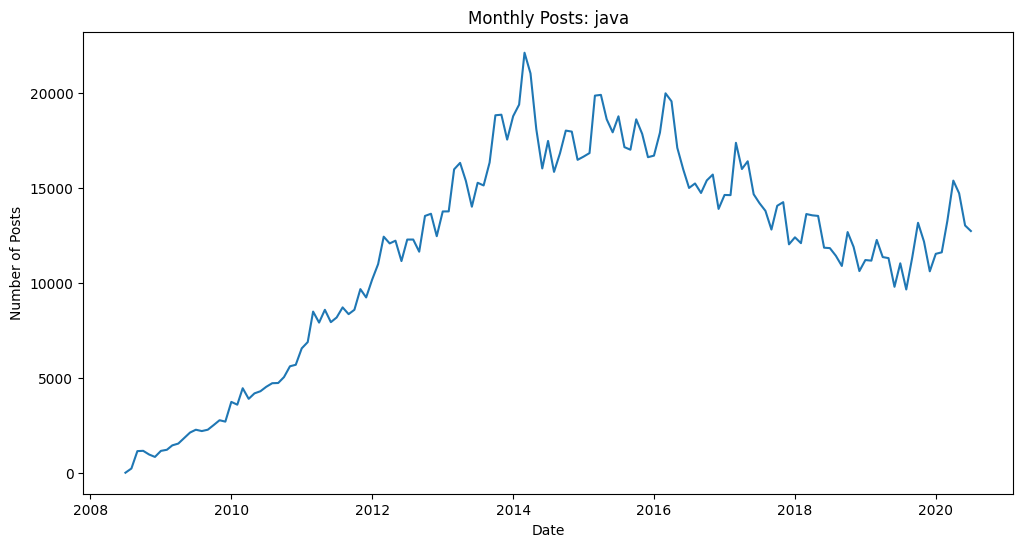

In [12]:
plt.figure(figsize=(12, 6))
plt.plot(reshaped_df.index, reshaped_df['java'])
plt.title('Monthly Posts: java')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.show()

## Compare Two Languages

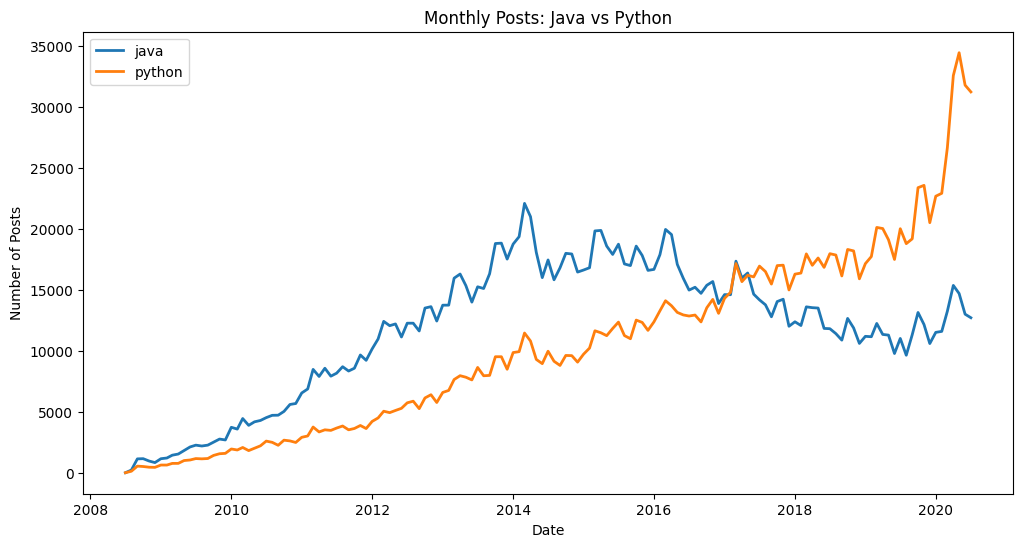

In [13]:
plt.figure(figsize=(12, 6))
plt.plot(reshaped_df.index, reshaped_df['java'], linewidth=2, label='java')
plt.plot(reshaped_df.index, reshaped_df['python'], linewidth=2, label='python')
plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Monthly Posts: Java vs Python')
plt.legend()
plt.show()

## All Languages (Raw Monthly Posts)

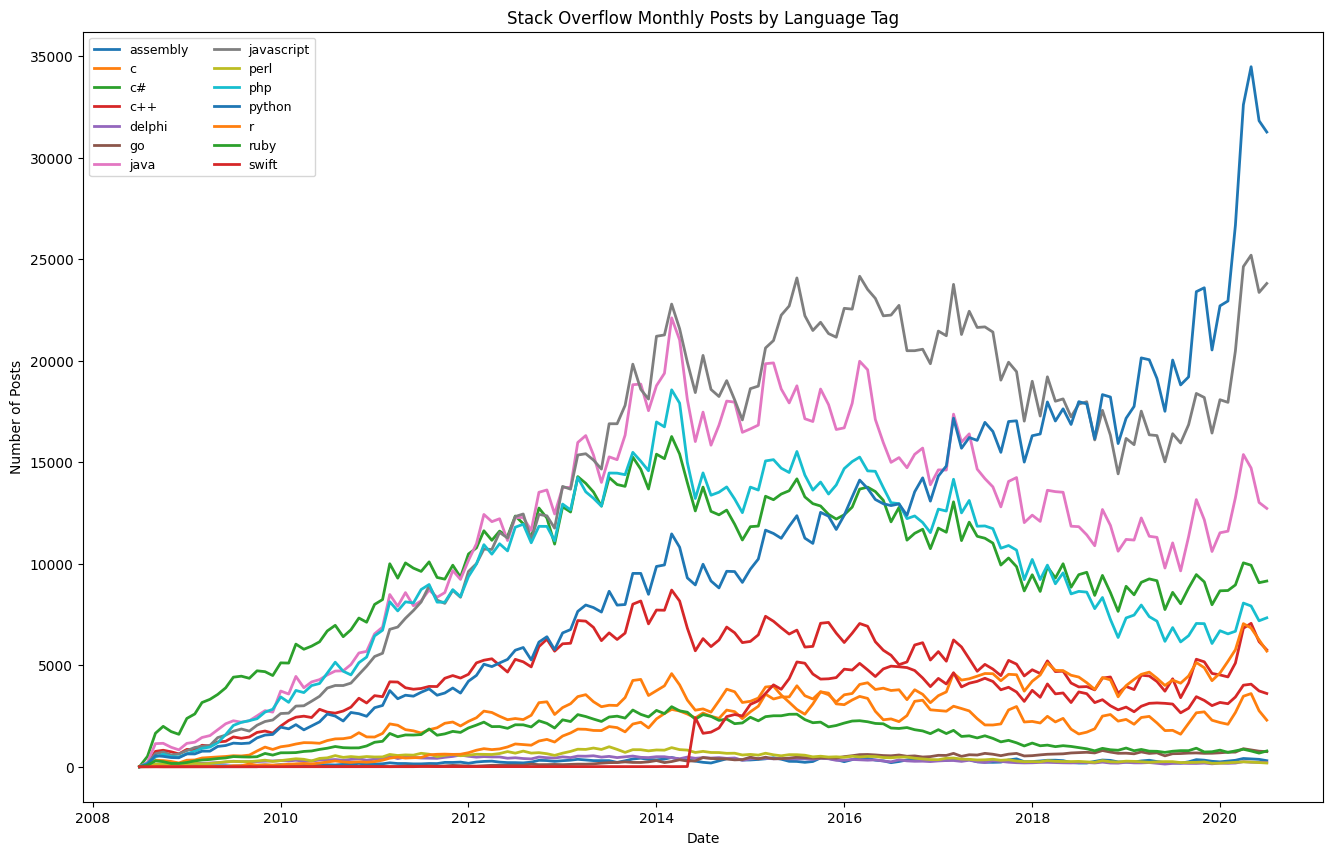

In [14]:
plt.figure(figsize=(16, 10))
for column in reshaped_df.columns:
    plt.plot(reshaped_df.index, reshaped_df[column], linewidth=2, label=column)

plt.xlabel('Date')
plt.ylabel('Number of Posts')
plt.title('Stack Overflow Monthly Posts by Language Tag')
plt.legend(fontsize=9, ncol=2)
plt.show()


# Smoothing with Rolling Mean

Time series can be noisy. We’ll smooth using a **6‑month rolling mean** to better see medium-term trends.


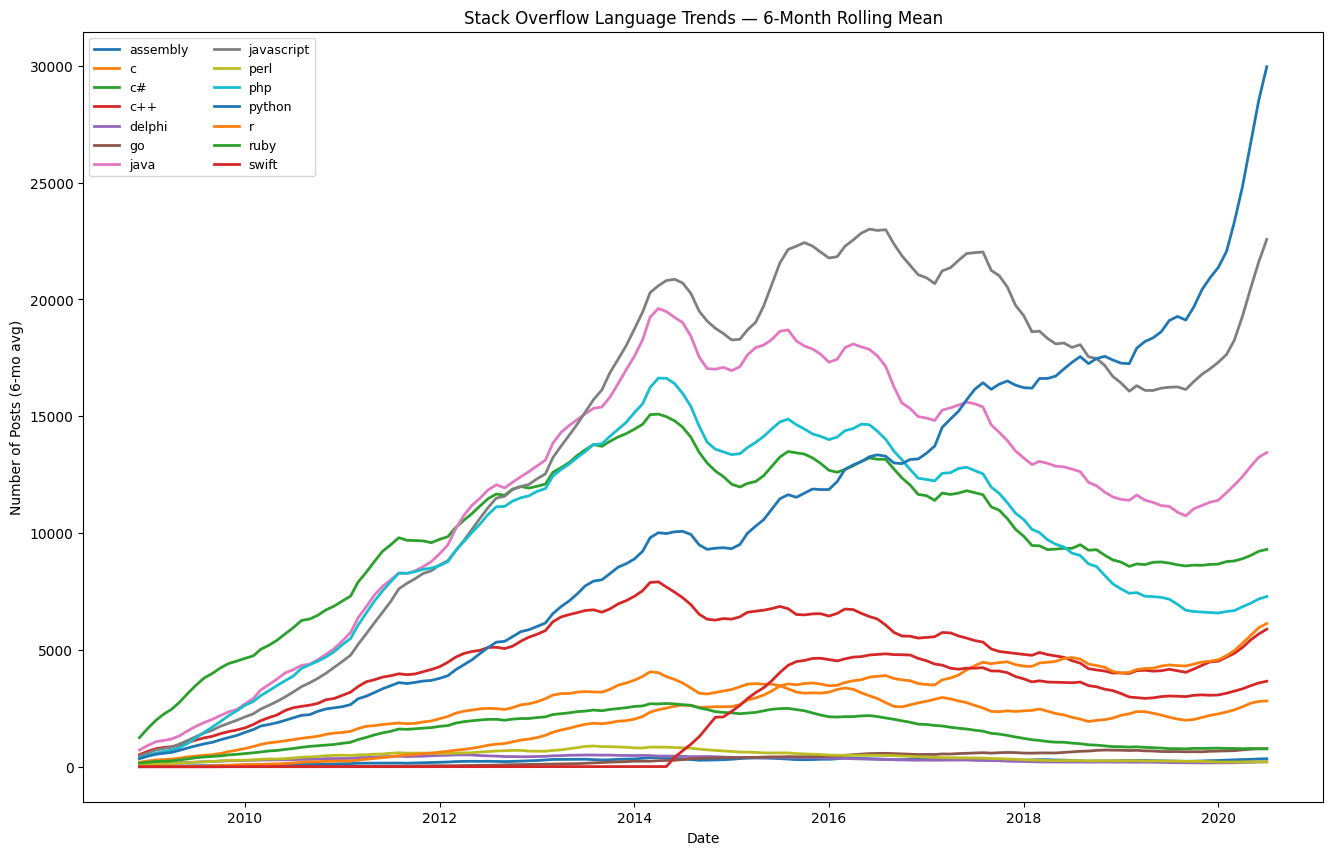

In [15]:
roll_df = reshaped_df.rolling(window=6).mean()

plt.figure(figsize=(16, 10))
for column in roll_df.columns:
    plt.plot(roll_df.index, roll_df[column], linewidth=2, label=column)

plt.xlabel('Date')
plt.ylabel('Number of Posts (6-mo avg)')
plt.title('Stack Overflow Language Trends — 6‑Month Rolling Mean')
plt.legend(fontsize=9, ncol=2)
plt.show()

## Totals & Rankings

In [16]:
# Total posts per language across the entire period
totals = reshaped_df.sum().sort_values(ascending=False)
print("Top languages by total posts:")
print(totals.head(10))

Top languages by total posts:
TAG
javascript   2,056,510
java         1,696,403
python       1,496,210
c#           1,423,530
php          1,361,988
c++            684,210
r              356,799
c              336,042
swift          273,055
ruby           214,582
dtype: float64



## Conclusion

- The **pivoted time series** makes it easy to compare languages over time.
- **Rolling averages** reveal medium-term trends that raw monthly series can hide.
- Totals across the full period highlight the **most discussed languages** overall, but recency trends may differ.
- For a fairer comparison across time, you might normalize by **total Stack Overflow activity** per month or compute **share of posts** per language.
